#Aim

To plot Meteorite Landings on a map.

---
Data - https://data.world/nasa/meteorite-landings

In [1]:
#Importing the necessary modules and reading the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("https://query.data.world/s/zvtucdq7abastx2eqrapoemmsb65er")
df["year"].head()

0    01/01/1880 12:00:00 AM
1    01/01/1951 12:00:00 AM
2    01/01/1952 12:00:00 AM
3    01/01/1976 12:00:00 AM
4    01/01/1902 12:00:00 AM
Name: year, dtype: object

As you can see, even though the column is named as `year` the data in the column is in datetime format.

So let's change the whole column into a `datetime` object and then extract only the years from it.

In [2]:
#Converting the year column to a datetime object and retrieving only the year values
df["year"] = pd.Series([datetime.date().year for datetime in pd.to_datetime(df["year"], errors = "coerce")])
df.head()

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775000, 6.083330)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.183330, 10.233330)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.216670, -113.000000)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.883330, -99.900000)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.166670, -64.950000)"


Let's check the data spread of the `year` column by plotting a boxplot.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


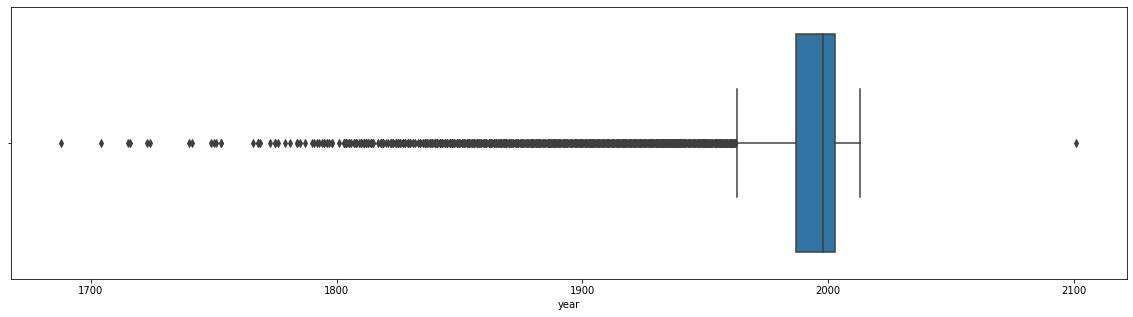

In [3]:
#Plotting a boxplot
plt.figure(figsize = (20,5))
sns.boxplot(df["year"])
plt.show()

The data in the years series has a lot of outliers. So let's try to clean the data to get rid of them.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


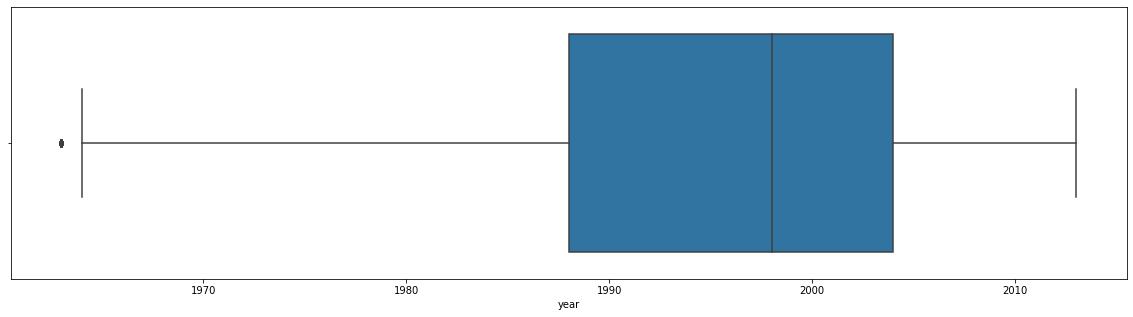

In [4]:
#Cleaning the year column from outliers
year_first_quartile = df["year"].quantile(0.25)
year_third_quartile = df["year"].quantile(0.75)
year_iqr = year_third_quartile - year_first_quartile

correct_years_df = df[(df["year"] >= year_first_quartile - (1.5 * year_iqr)) & (df["year"] <= year_third_quartile + (1.5 * year_iqr))]

plt.figure(figsize = (20,5))
sns.boxplot(correct_years_df["year"])
plt.show()

Now the data has almost no outliers, and that's what I wanted.

---

The next thing to now check for are the correct latitude and longitude values.

From common knowledge, we know that the possible values for latitudes are from -90 to 90 and the possible values for longitudes are from -180 to 180.

In [5]:
#Cleaning the data from invalid latitude and longitude values
correct_lat_df = correct_years_df[(correct_years_df["reclat"] >= -90) & (correct_years_df["reclat"] <= 90)]
correct_lat_long_df = correct_years_df[(correct_years_df["reclong"] >= -180) & (correct_years_df["reclong"] <= 180)]

In the data there are excessive numbers of row with the location as (0,0). This might indicate some fault in the data, so let's remove any rows with the location as (0,0).

In [6]:
correct_lat_long_df = correct_lat_long_df[~((correct_lat_long_df["reclong"] == 0) & (correct_lat_long_df["reclat"] == 0))]
print(f"Number of values excluded = {df.shape[0] - correct_lat_long_df.shape[0]}")

Number of values excluded = 15645


As you can see, since the start of the project I've excluded `9460` values from the original data showing that the data was surely in need for some cleaning.

Now let's check if there are any null values left.

In [7]:
#Checking for null values
correct_lat_long_df.isna().sum()

name            0
id              0
nametype        0
recclass        0
mass (g)       68
fall            0
year            0
reclat          0
reclong         0
GeoLocation     0
dtype: int64

The column mass still has 68 `null values` in it. Let's replace them with the `median` value of the `mass (g)` column.

In [8]:
#Replacing the null values in the mass column
null_indices = correct_lat_long_df[correct_lat_long_df["mass (g)"].isna() == True].index
correct_lat_long_df.loc[null_indices, "mass (g)"] = correct_lat_long_df["mass (g)"].median()
correct_lat_long_df.isna().sum()

name           0
id             0
nametype       0
recclass       0
mass (g)       0
fall           0
year           0
reclat         0
reclong        0
GeoLocation    0
dtype: int64

As you can see, we have succesfully replaced all null values of the column with the median values and rid the dataframe with any kind of null values.

---
Before we plot the landings on a map, let's divide the meteorites according to their `nametype` and plot histograms and countplots to understand the landings per year.

And because we can only plot the locations of a confirmed meteorite, we'll only plot the meteorites with `fall` as `Found` and not `Fell`

In [9]:
#Dividing the data into two
valid_found_df = correct_lat_long_df[(correct_lat_long_df["nametype"] == "Valid") & (correct_lat_long_df["fall"] == "Found")]
relict_found_df = correct_lat_long_df[(correct_lat_long_df["nametype"] == "Relict") & (correct_lat_long_df["fall"] == "Found")]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


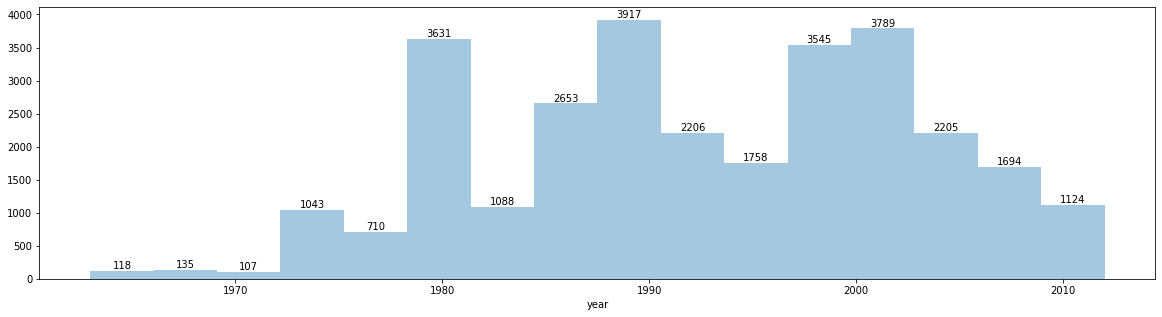

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


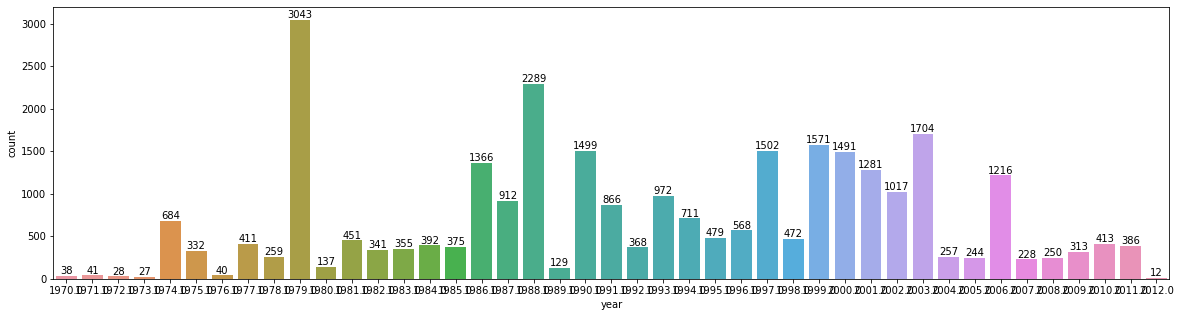

In [10]:
#Plotting the histogram and countplot for the Valid and Found dataframe
plt.figure(figsize = (20,5))
bars = sns.distplot(valid_found_df["year"], bins = "sturges", kde = False)
for bar in bars.patches:
  bars.annotate(s = str(int(bar.get_height())), xy = ((bar.get_x() + bar.get_width()/2), bar.get_height()), ha = "center", va = "bottom")
plt.show()

plt.figure(figsize = (20,5))
bars = sns.countplot(valid_found_df.loc[valid_found_df["year"] >= 1970, "year"])
for bar in bars.patches:
  bars.annotate(s = str(int(bar.get_height())), xy = ((bar.get_x() + bar.get_width()/2), bar.get_height()), ha = "center", va = "bottom")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


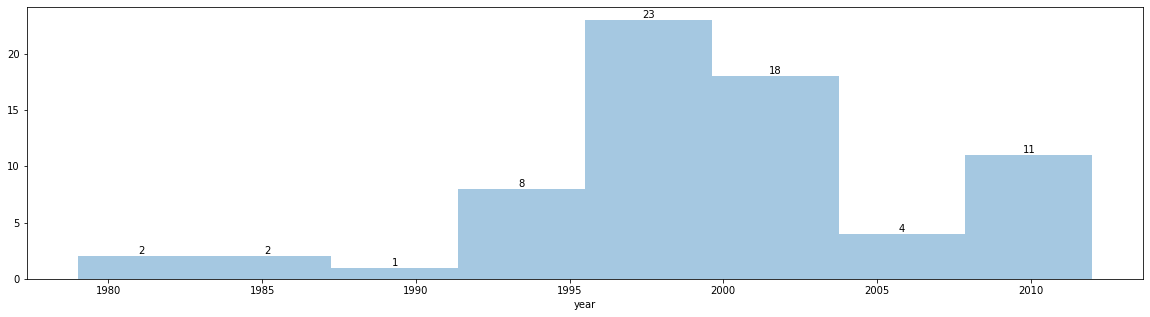

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


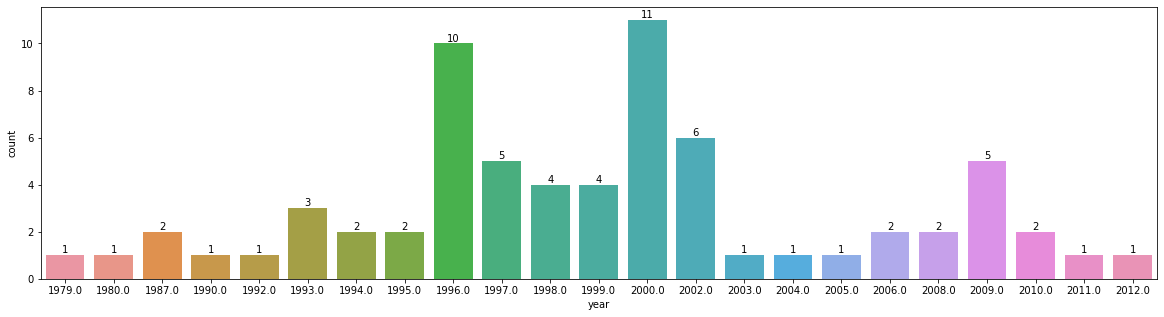

In [11]:
#Plotting the histogram and countplot for the Relict and Found dataframe
plt.figure(figsize = (20,5))
bars = sns.distplot(relict_found_df["year"], bins = "sturges", kde = False)
for bar in bars.patches:
  bars.annotate(s = str(int(bar.get_height())), xy = ((bar.get_x() + bar.get_width()/2), bar.get_height()), ha = "center", va = "bottom")
plt.show()

plt.figure(figsize = (20,5))
bars = sns.countplot(relict_found_df.loc[relict_found_df["year"] >= 1970, "year"])
for bar in bars.patches:
  bars.annotate(s = str(int(bar.get_height())), xy = ((bar.get_x() + bar.get_width()/2), bar.get_height()), ha = "center", va = "bottom")
plt.show()

In [12]:
print(f"Number of Valid and Found landings = {valid_found_df.shape[0]}")
print(f"Number of Valid and Found landings = {relict_found_df.shape[0]}")

Number of Valid and Found landings = 29723
Number of Valid and Found landings = 69


As it's clear from the graphs and size of the Valid and Found dataframe, plotting all the landings won't be possible. So I'll just plot the landings from the year 2007 because it has a moderate 228 landings and also because it is one of the most recent years in the data.

For the Relict and Found dataframe, plotting all the landings is possible because the data itself has only 69 landings.

---
Now let's plot the maps!

In [13]:
#Importing the necessary modules
import folium as fl

In [14]:
#Plotting all the Valid and Found meteorites from the year 2012 on a map
map = fl.Map(location = [0,0], zoom_start = 2, height = "95%", width = "95%")
for meteorite in valid_found_df.loc[valid_found_df["year"] == 2007, :].index:
  fl.Marker(location = [valid_found_df.loc[meteorite, "reclat"], valid_found_df.loc[meteorite, "reclong"]], popup = valid_found_df.loc[meteorite, "name"]).add_to(map)
map

In [15]:
#Plotting all the Relict and Found meteorites on a map
map = fl.Map(location = [0,0], zoom_start = 2, height = "95%", width = "95%")
for meteorite in relict_found_df.loc[:, :].index:
  fl.Marker(location = [relict_found_df.loc[meteorite, "reclat"], relict_found_df.loc[meteorite, "reclong"]], popup = relict_found_df.loc[meteorite, "name"]).add_to(map)
map

---
#END OF THE PROJECT
---